In [1]:
import os
import pandas as pd

import numpy as np
import re

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

pd.set_option('display.max_columns', 100)

#from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import math
import time

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
xls = pd.ExcelFile(r'/data/MGP/TestPoints_20220203_ResFeasible.xlsx')
df=pd.read_excel(xls,'ResFeasible',header=1).dropna(how='all', axis=1)
df.drop('#',axis=1,inplace=True)
            


TypeError: to_pickle() missing 1 required positional argument: 'filepath_or_buffer'

In [3]:
print(df.shape)
df.head()

(63459, 36)


,Liquid density [kg/m3],Liquid \nviscosity\n [Pa.s],Gas molar mass \n[g/mol],Gas inlet compressibility\n,Hub radius [m],Tip radius [m],Stage 1 [y=1/n=0],Tin [K],Pin [kPa],GVFin,Qin [m3/s],N [rpm],phi,Gas Viscosity,GMF,Qv_liq @inlet,Qv_gas @inlet,DR @inlet,Tout [K],Pout [kPA],GVFout,Qv_out [m3/s],Efficacy,Efficacy @ref,Etap,Qm [kg/s],Power [kW],Hp [kJ/kg],Axial Power losses [kW],Side wall windage loss [kW],Rotor-diffuser windage [kW],total mechanincal loss [kW],Surge Distance,Total Consumed power,Differential Pressure DeltaP [kPa],Original Order
0,989.321765,0.000558,28.013,0.999146,0.14,0.16,1,322.017877,1867.320507,44.657495,0.098486,4220.190859,0.078815,0.000020,0.015699,0.054504,0.043981,50.591576,1,2601.877842,36.673534,0.086069,0.959594,0.897838,0.440161,54.782461,194.789217,1.565075,35.354530,9.941665,8.930387,106.731887,3.706551,301.521104,734.557335,1
1,997.303292,0.000839,28.013,0.996045,0.14,0.16,1,300.789449,2261.871734,22.560723,0.048801,2041.082876,0.080749,0.000019,0.007376,0.037791,0.011010,39.205899,1,2478.373546,21.003848,0.047839,0.908268,0.969289,0.439472,37.969332,29.656316,0.343254,17.295614,1.720538,1.765649,31.377189,14.186424,61.033505,216.501812,2
2,992.909998,0.000611,28.013,1.001839,0.14,0.16,1,316.852547,5056.459294,45.132048,0.073742,2638.732515,0.094382,0.000020,0.042570,0.040461,0.033281,18.499881,1,5276.183985,44.081047,0.072356,0.886056,0.873196,0.431152,41.960357,48.154779,0.494801,22.269798,2.587538,2.481568,42.433367,24.190271,90.588146,219.724690,4
3,979.249421,0.000400,28.013,1.006971,0.14,0.16,1,344.056608,4641.124807,48.896181,0.124495,3490.396483,0.120461,0.000021,0.042239,0.063622,0.060873,21.695393,1,4831.194752,47.893822,0.122100,0.811021,0.614530,0.448571,65.049137,68.002181,0.468935,29.328158,5.230348,4.616359,67.117871,58.504924,135.120051,190.069944,5
4,991.458984,0.000593,28.013,0.999425,0.14,0.16,1,318.474477,3259.999596,39.688098,0.095659,4132.563946,0.078176,0.000020,0.022392,0.057694,0.037965,28.729789,1,4037.200216,34.698864,0.088350,0.988318,0.901294,0.465193,58.511227,195.016966,1.550481,34.631867,10.315960,9.345548,108.934303,2.866052,303.951269,777.200620,7


In [4]:
data=df[['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Differential Pressure DeltaP [kPa]', 'Qin [m3/s]', 'Pout [kPA]', 'GVFin', 'Hp [kJ/kg]', 'GVFout','Qv_out [m3/s]','phi','Surge Distance']]

In [5]:
Phi_Surge = 0.076
data['Surge Distance_from_eq'] = 100 * (data['phi'] - Phi_Surge) / Phi_Surge

/tmp/ipykernel_13129/1574791833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Surge Distance_from_eq'] = 100 * (data['phi'] - Phi_Surge) / Phi_Surge


In [7]:
data[['Surge Distance_from_eq','Surge Distance']].head(20)

,Surge Distance_from_eq,Surge Distance
0,3.704108,3.706551
1,6.248715,14.186424
2,24.187345,24.190271
3,58.501190,58.504924
4,2.863629,2.866052
5,68.193270,68.197232
6,26.463122,26.466101
7,30.464870,30.467943
8,49.085224,49.088736
9,63.872982,63.876842


In [8]:
# since this xgb version does not recognise column names with square brackets, commas,\ they need to be replaced with _ 
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
# since this xgb version does not recognise column names with square brackets, commas need to replace the column names.
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

INPUT_C=['Tin _K_','Pin _kPa_','N _rpm_','Total Consumed power','Differential Pressure DeltaP _kPa_'] #
OUTPUT_C =['GVFin','Qin _m3/s_','GVFout','Qv_out _m3/s_']#,'Phi_Surge'] #,'Hp _kJ/kg_','phi']
X_1=data[INPUT_C]
y_1=data[OUTPUT_C]


In [9]:

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split

train_X1, test_X1, train_y1, test_y1 = train_test_split(X_1, y_1, train_size=0.8, random_state=32)

In [10]:
train_X1.shape, test_X1.shape, train_y1.shape, test_y1.shape

train_y=train_y1.copy() 
test_y=test_y1.copy() 

import time
start_time = time.time()
print(time.asctime( time.localtime(time.time()) ))

# Try a simple XGB model
other_params={'learning_rate':0.1,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
#xgb_regressor=xgb.XGBRegressor(objective='reg:squarederror',**other_params).fit(X,y)
#prediction_all=xgb_regressor.predict(X)
multioutputregressor_1=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X1, train_y)

print("--- %s seconds ---" % (time.time() - start_time))

Thu Mar 17 10:28:19 2022
--- 526.5767142772675 seconds ---


In [12]:
A = multioutputregressor_1.predict(data[INPUT_C])
for i, out in enumerate(OUTPUT_C):
    data[out+'_pred'] = A[:,i]

/tmp/ipykernel_13129/2769630592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[out+'_pred'] = A[:,i]


In [13]:
for i, out in enumerate(OUTPUT_C):
    data[out+'_residuals'] = data[out] - data[out+'_pred']

/tmp/ipykernel_13129/1485066508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[out+'_residuals'] = data[out] - data[out+'_pred']
/tmp/ipykernel_13129/1485066508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[out+'_residuals'] = data[out] - data[out+'_pred']
/tmp/ipykernel_13129/1485066508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [14]:
# predictions on test set
data_test = data.iloc[test_y.index]

test_y_pred = data_test[['GVFin_pred','Qin _m3/s__pred','GVFout_pred','Qv_out _m3/s__pred']] #,'Phi_Surge_pred']]

predictions_1=multioutputregressor_1.predict(test_X1)

# Get the performance of predictions on all output parameters
print('Root_mean_squared_error_test set_',math.sqrt(mean_squared_error(test_y,test_y_pred)))
print('R2 Score_test set_xgb',r2_score(test_y,test_y_pred))

Root_mean_squared_error_test set_ 2.159942076965726
R2 Score_test set_xgb 0.9757733022735


In [15]:
# Nice table for metrics
dfppt=pd.DataFrame(columns=['Variable','RMSE','R²'])
A=[];B=[];C=[]
for i, out in enumerate(OUTPUT_C):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_y[out],test_y_pred[out+'_pred'])),4))
    C.append(round(r2_score(test_y[out],test_y_pred[out+'_pred']),4)) 
dfppt['Variable']=A
dfppt['RMSE']=B
dfppt['R²']=C
dfppt

,Variable,RMSE,R²
0,GVFin,3.1235,0.9798
1,Qin _m3/s_,0.0054,0.9727
2,GVFout,2.9841,0.9812
3,Qv_out _m3/s_,0.0053,0.9694


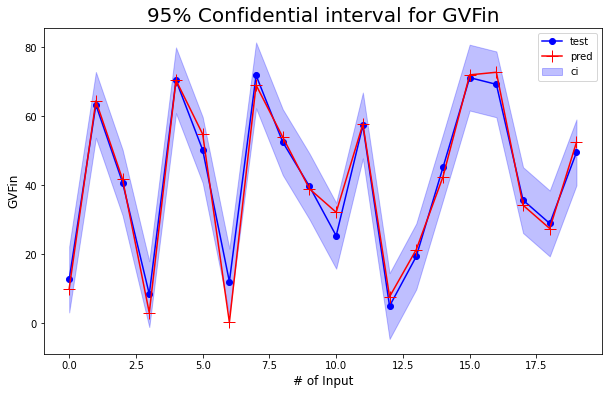

In [16]:
import matplotlib.pyplot as plt

n_points=20
#output = 'Phi_Surge'
output = 'GVFin'
#x, pred, y = range(len(predictions_1))[:n_points], test_y1[output][:n_points], predictions_1[:,4][:n_points]
x, pred, y = range(len(test_y))[:n_points], test_y[output][:n_points], test_y_pred[output+'_pred'][:n_points]

ci = 1.96 * np.std(y)/np.sqrt(len(x))

plt.figure(figsize=(10,6))
plt.plot(x, y, color='b', marker='o', label='test')
plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.25, label='ci')
plt.title('95%% Confidential interval for %s' %output, fontsize=20)
plt.ylabel(output, fontsize=12)
plt.xlabel('# of Input', fontsize=12)
plt.legend()
plt.show()

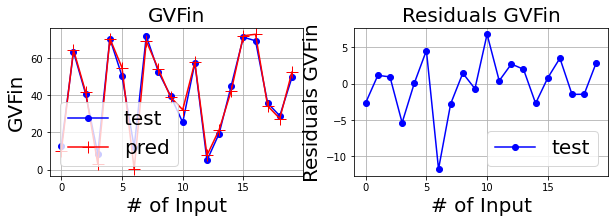

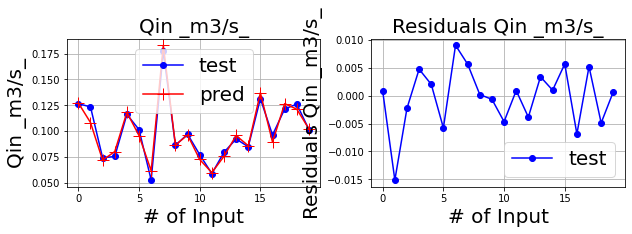

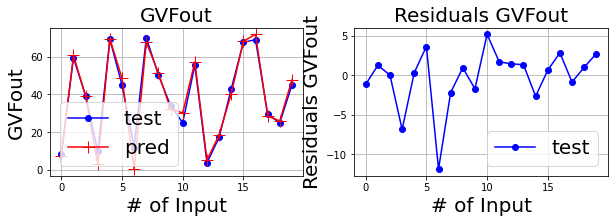

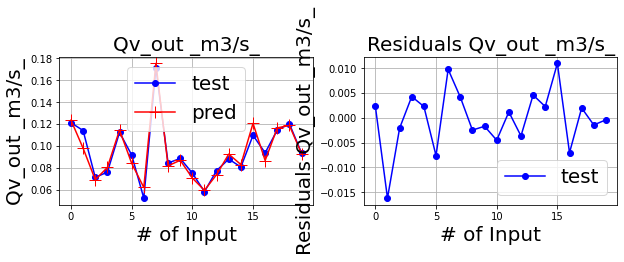

In [17]:
for ii,output in enumerate(OUTPUT_C):

#     x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
    x, pred, y = range(len(test_y))[:n_points], test_y[output][:n_points], test_y_pred[output+'_pred'][:n_points]
    residual = pred - y

    plt.figure(figsize=(10,6))    
    plt.subplot(221)

    plt.plot(x, y, color='b', marker='o', label='test')
    plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
    plt.title(output, fontsize=20)
    plt.ylabel(output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)

    
    plt.subplot(222)
    plt.plot(x, residual, color='b', marker='o', label='test')
    plt.title('Residuals '+output, fontsize=20)
    plt.ylabel('Residuals '+output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    
    plt.show()    

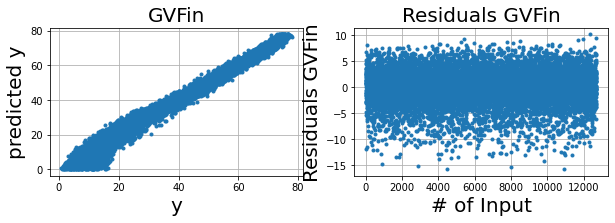

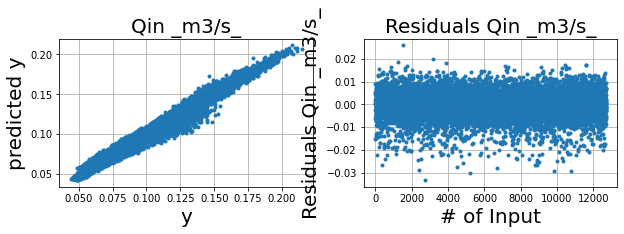

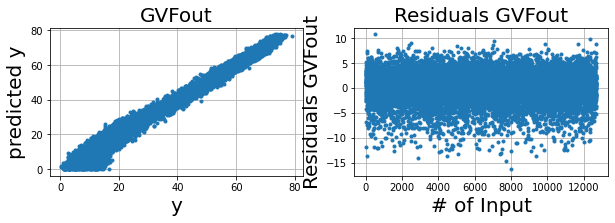

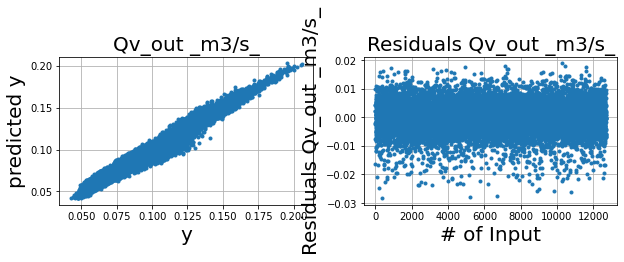

In [18]:
for ii,output in enumerate(OUTPUT_C):

#     x, pred, y = range(len(predictions_1))[:], test_y[output][:], predictions_1[:,ii][:]
    x, pred, y = range(len(test_y)), test_y[output], test_y_pred[output+'_pred']
    residual = pred - y

    plt.figure(figsize=(10,6))    
    plt.subplot(221)

    plt.plot(y, pred, '.') #color='b', marker='o', label='test')
    plt.title(output, fontsize=20)
    plt.ylabel('predicted y', fontsize=20)
    plt.xlabel('y', fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True)

    
    plt.subplot(222)
    plt.plot(x, residual, '.') #color='b', marker='o', label='test')
    plt.title('Residuals '+output, fontsize=20)
    plt.ylabel('Residuals '+output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True)
    
    plt.show() 

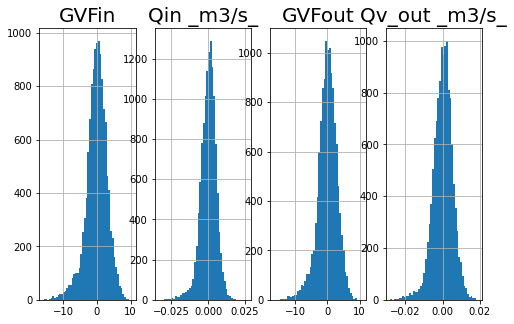

In [19]:
plt.figure(figsize=(10,5)) 
for ii,output in enumerate(OUTPUT_C):

    residual = data_test[output+'_residuals'] #pred - y
   
    plt.subplot(1,5,ii+1)

    plt.hist(residual,bins=50)
    plt.title(output, fontsize=20)
#     plt.ylabel(output, fontsize=20)
#     plt.xlabel('# of Input', fontsize=20)
    plt.grid(True)
    
    #plt.show() 

In [20]:
data_test[['GVFin_residuals', 'Qin _m3/s__residuals', 'GVFout_residuals', 'Qv_out _m3/s__residuals']].describe()

,GVFin_residuals,Qin _m3/s__residuals,GVFout_residuals,Qv_out _m3/s__residuals
count,12692.000000,12692.000000,12692.000000,12692.000000
mean,-0.031525,0.000089,-0.018482,0.000108
std,3.123489,0.005364,2.984174,0.005315
min,-15.693501,-0.033332,-16.298937,-0.028294
25%,-1.702823,-0.003020,-1.684271,-0.003029
50%,0.148657,0.000475,0.146143,0.000404
75%,1.963991,0.003556,1.942452,0.003564
max,10.187195,0.026071,10.745019,0.018855


In [21]:
import math
data['phi_pred']=data['Qin _m3/s__pred']/(data['N _rpm_']/60*2*math.pi*0.15*0.01885)

/tmp/ipykernel_13129/1046405365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['phi_pred']=data['Qin _m3/s__pred']/(data['N _rpm_']/60*2*math.pi*0.15*0.01885)


In [22]:
# phi_surge=0.076
data['Surge Distance_pred'] = 100*(data['phi_pred']-Phi_Surge)/Phi_Surge 

/tmp/ipykernel_13129/3395722811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Surge Distance_pred'] = 100*(data['phi_pred']-Phi_Surge)/Phi_Surge


In [23]:
LAST_RESIDUALS = ['phi','Surge Distance']
for col in LAST_RESIDUALS:
    data[col+'_residuals'] = data[col] - data[col+'_pred']

/tmp/ipykernel_13129/1377259750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'_residuals'] = data[col] - data[col+'_pred']
/tmp/ipykernel_13129/1377259750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'_residuals'] = data[col] - data[col+'_pred']


In [24]:
#data.drop('Phi_pred',axis=1,inplace=True)

#Overwriting data_test to add the last 4 columns
data_test = data.iloc[test_y.index]

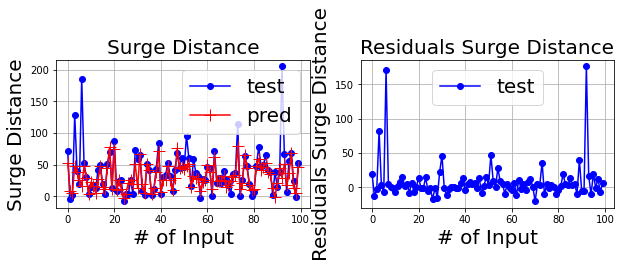

In [25]:
#for ii,output in enumerate(output_c):
output = 'Surge Distance'
data1=data_test.head(100)
data1.reset_index(inplace=True)

# x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
# residual = pred - y

plt.figure(figsize=(10,6))    
plt.subplot(221)

plt.plot(data1.index, data1['Surge Distance'], color='b', marker='o', label='test')
plt.plot(data1.index, data1['Surge Distance_pred'], color='red', marker='+', markersize=12, label='pred')
plt.title(output, fontsize=20)
plt.ylabel(output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)


plt.subplot(222)
#plt.figure(figsize=(10,6))
plt.plot(data1.index, data1['Surge Distance']-data1['Surge Distance_pred'], color='b', marker='o', label='test')
plt.title('Residuals '+output, fontsize=20)
plt.ylabel('Residuals '+output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)

plt.show()

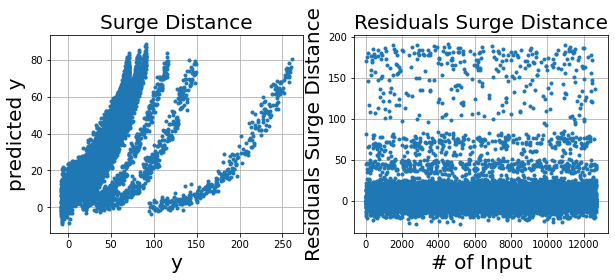

In [26]:
output = 'Surge Distance'

plt.figure(figsize=(10,8))    
plt.subplot(221)

plt.plot(data_test['Surge Distance'], data_test['Surge Distance_pred'], '.') #color='b', marker='o', label='test')
plt.title(output, fontsize=20)
plt.ylabel('predicted y', fontsize=20)
plt.xlabel('y', fontsize=20)
plt.grid(True)


plt.subplot(222)
#plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,len(data_test.index),len(data_test.index)), data_test['Surge Distance_residuals'], '.') #color='b', marker='o', label='test')
plt.title('Residuals '+output, fontsize=20)
plt.ylabel('Residuals '+output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.grid(True)

plt.show()

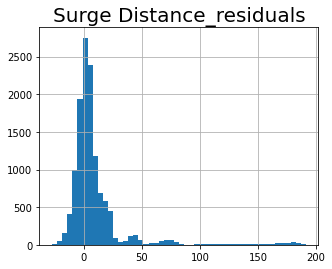

In [27]:
plt.figure(figsize=(5,4)) 

output = 'Surge Distance_residuals'

plt.hist(data_test['Surge Distance_residuals'],bins=50)
plt.title(output, fontsize=20)
#     plt.ylabel(output, fontsize=20)
#     plt.xlabel('# of Input', fontsize=20)
plt.grid(True)
    
#plt.show() 

In [28]:
output_c2=['Surge Distance']
for i, out in enumerate(output_c2):
    print(f'RMSE_test set_{out}', math.sqrt(mean_squared_error(data_test[out],data_test[out+'_pred'])))
    print(f'R2 Score_test set_xgb_{out}', r2_score(data_test[out],data_test[out+'_pred']))
    print('________________________________\n')

RMSE_test set_Surge Distance 29.437286187337147
R2 Score_test set_xgb_Surge Distance 0.3188899622210888
________________________________

